
# 👁️ **Step 1: Visual Validation of Blink Annotations Against Signal Data**

This is the **first step** in the blink analysis pipeline. It focuses on **visually verifying** that the manually labeled blink events—annotated by a human expert in **CVAT**—are properly aligned with physiological signal data:

* **EAR (Eye Aspect Ratio)** time series
* **EEG/EOG signals**

---

## 🎯 **Purpose of This Step**

Before performing any analysis, we need to **validate the accuracy** of the blink annotations. These labels were created **manually in CVAT**, by identifying:

* 🟢 When the blink **starts**
* 🔴 When the eye is **fully closed** (minimum EAR)
* 🟢 When the blink **ends**

These annotations are made on a **frame basis** (e.g., 30 Hz video) and must be **mapped** to high-frequency sample-based physiological signals (e.g., EEG at 500–1000 Hz).
This phase ensures the labels visually tally with the signal data before any downstream processing.

---

## ✨ **What This Script Does**

* Loads raw `.fif` eye-tracking + EEG data and CVAT `.zip` annotations
* Extracts blink intervals and converts them to time-series sample indices
* Plots:

  * EAR and EEG signals
  * Blink annotations (start, min, end) overlaid on signals
* Exports visual PDF reports for inspection

---

## 📦 **Inputs Required**

| File                      | Description                                       |
| ------------------------- | ------------------------------------------------- |
| `S01_20170519_043933.fif` | Raw physiological data (EEG, EAR, etc.)           |
| `S01_20170519_043933.zip` | Blink annotations from CVAT (JSON/XML inside ZIP) |

---

## 🧠 **How Blink Intervals Are Extracted**

The function `extract_blink_durations(...)` handles the critical step of **converting frame-based CVAT annotations** into **sample indices** that align with high-frequency time-series data (e.g., EEG):

```python
def extract_blink_durations(annotation_df, frame_offset, sfreq, video_fps):
    ...
```

### 🛠️ What It Does:

* Processes blink annotations that appear in **triplets**:
  `start → min → end`
* Subtracts a **frame offset** (if any cropping or indexing shift is needed)
* Converts CVAT **video frame indices** to **sample indices** for time series, using:

  ```
  sample_index = (frame_index - offset) * (sfreq / video_fps)
  ```

### 📤 Output Columns:

| Column                               | Description                                           |
| ------------------------------------ | ----------------------------------------------------- |
| `startFrame`, `endFrame`, `minFrame` | Original CVAT frame indices                           |
| `startBlinks_cvat`, `...`            | Adjusted frame indices after offset                   |
| `startBlinks`, `...`                 | Final sample indices aligned to time series           |
| `blink_type`                         | Type/category of blink (e.g., 'blink', 'long\_blink') |

✅ This ensures that annotation markers precisely line up with the raw signals.

---

---

## 📘 **Overview of the 3 Steps**

| Step | Description                                      |
| ---- | ------------------------------------------------ |
| 1️⃣  | Visualize overall time-series signal (EAR + EEG) |
| 2️⃣  | Plot each blink with start, min, and end markers |
| 3️⃣  | Save a consolidated visual report using MNE      |

---

## 🧪 **Step 1a: Plot the Full Time-Series Signal**

This helps you check for:

* Overall quality of the data
* Expected variations in EAR and EEG/EOG
* Regions of interest for blinks

```python
raw.plot(
    picks=['avg_ear', 'E8'],
    block=True,
    show_scrollbars=False,
    title='avg_ear Blink Signal'
)
```

---

## 🧩 **Step 1b: Inspect Blink Intervals One-by-One**

Each blink is annotated by a triplet: `start`, `min`, `end`. This step plots those over the EAR signal for **detailed inspection**.

```python
for _, row in blink_df.iterrows():
    plot_with_annotation_lines(
        raw=raw,
        start_frame=row['startBlinks'],
        end_frame=row['endBlinks'],
        mid_frame=row['blink_min'],
        picks='avg_ear',
        sfreq=sfreq,
    )
```

This lets you manually verify that annotations are consistent with the physiological signal dips and recoveries.

---

## 📊 **Step 1c: Generate HTML Report with MNE**

Instead of viewing blink events one by one, this step **automatically generates a consolidated HTML report** using **MNE’s reporting tool**.

```python
generate_blink_reports(
    raw=raw,
    blink_df=blink_df,
    picks='avg_ear',
    sfreq=sfreq,
    output_dir='blink_reports',
    base_filename='blink_report',
    max_events_per_report=40
)
```

### 📂 Output:

```
blink_reports/
└── blink_report.html
```

The report provides a scrollable interface to review blink events in bulk with annotation markers.



---

## ⚙️ **Behind the Scenes: Blink Frame Mapping**

The function `extract_blink_durations(...)` ensures frame-based CVAT labels are aligned with high-frequency signal data:

```python
sample_index = (frame_index - offset) * (sfreq / video_fps)
```

This mapping converts frame labels to time-series sample indices that can be plotted accurately.

---

## 📌 **Why This Step Is Critical**

✅ Confirms label–signal alignment
✅ Flags mislabeled or shifted annotations early
✅ Builds confidence in the dataset before training models or running statistics

---

## ⚠️ **Reminder**

> This is a **quality control step**.
> Visual inspection is **mandatory** to catch any misalignments between annotations and raw signals.


Loading cached FIF from: ./_debug_cache\cached_raw.pkl
Loading cached annotations from: ./_debug_cache\cached_annotations.pkl


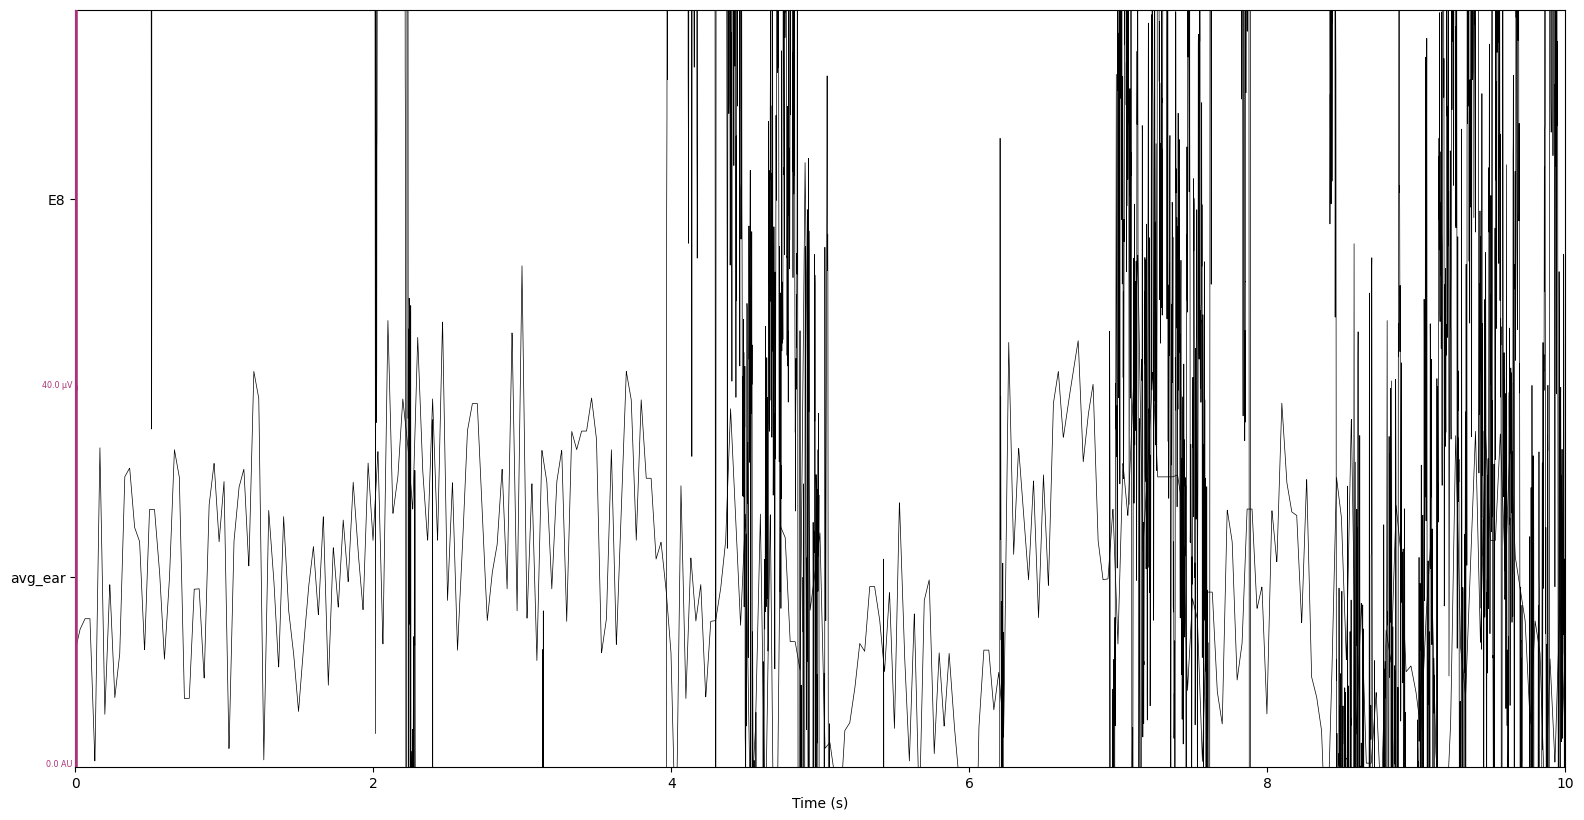

⚠️ WARNING: Only plotting the first 10 blink events...


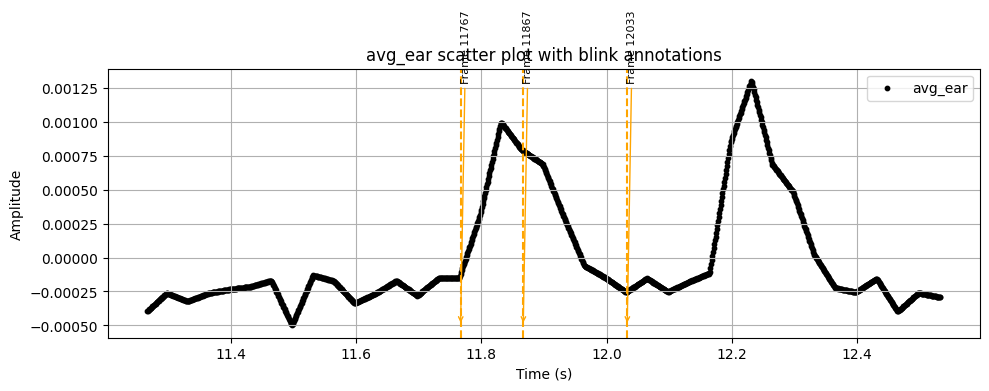

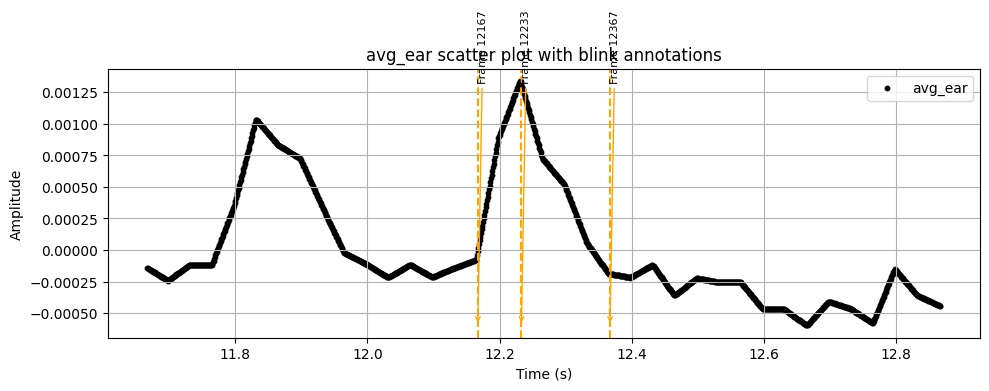

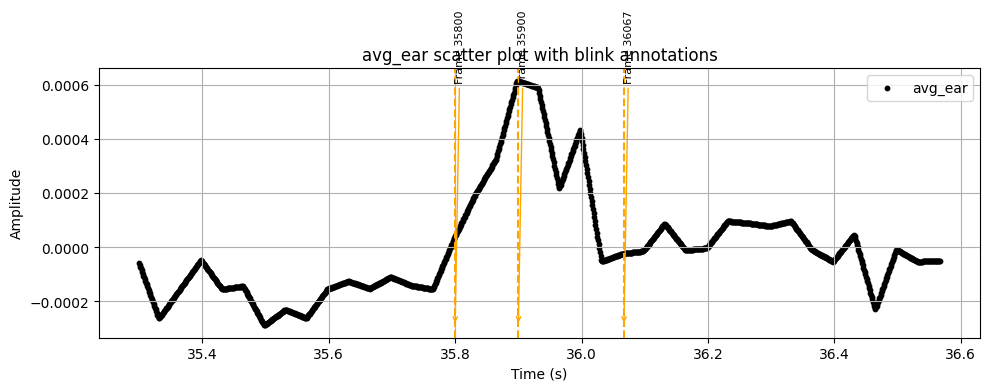

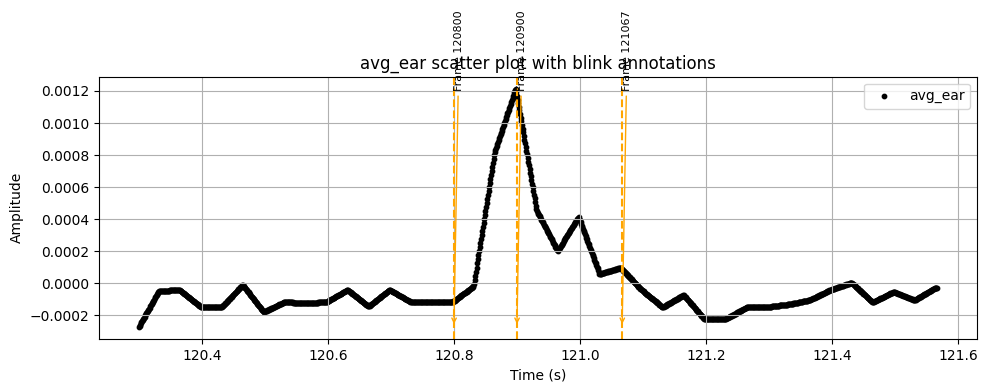

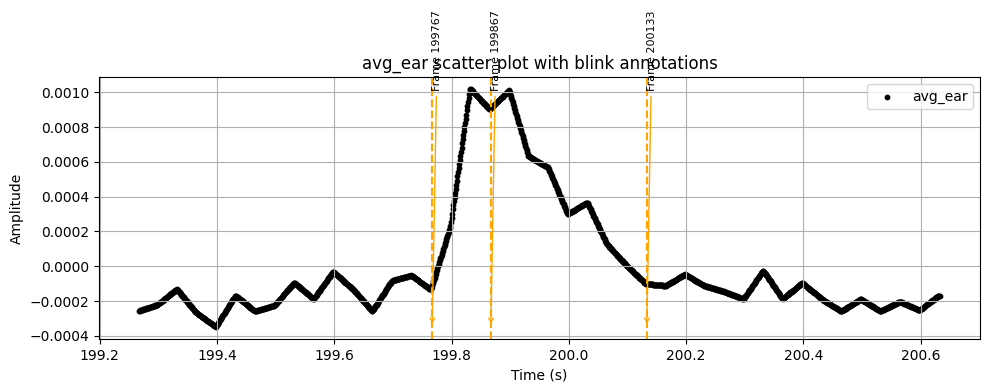

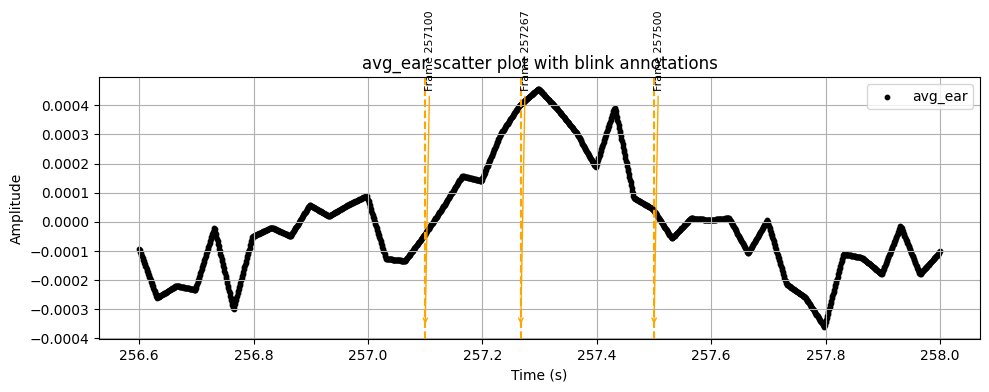

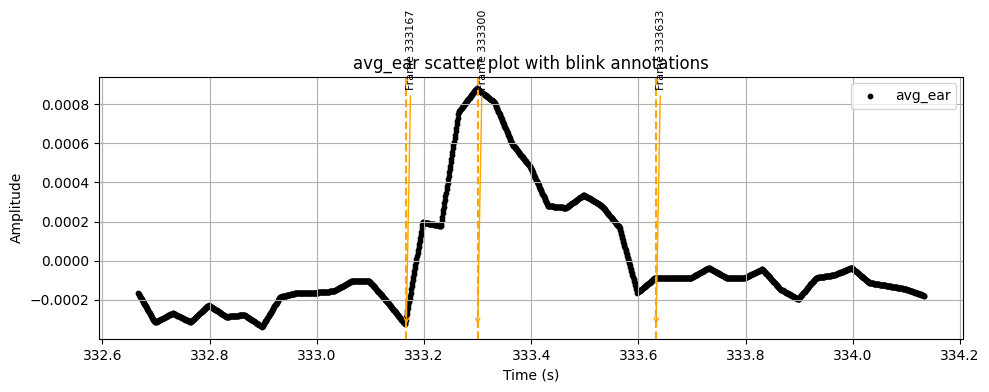

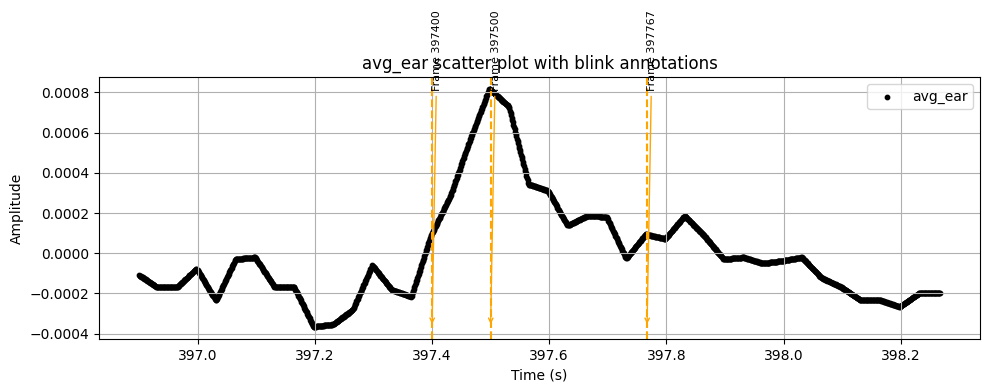

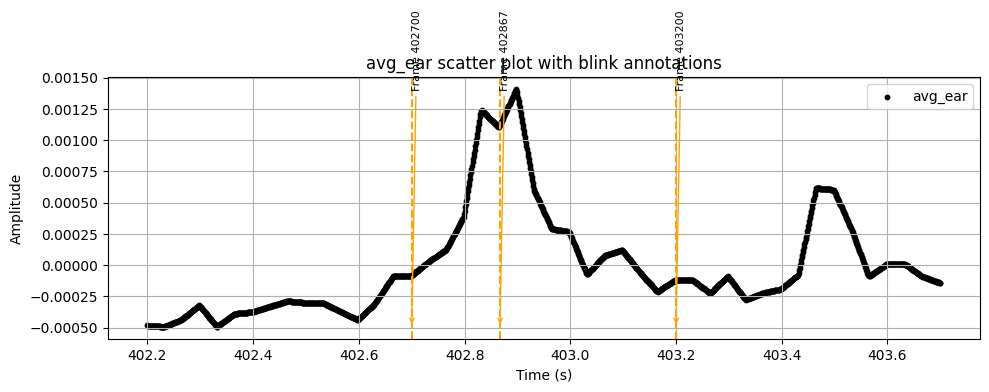

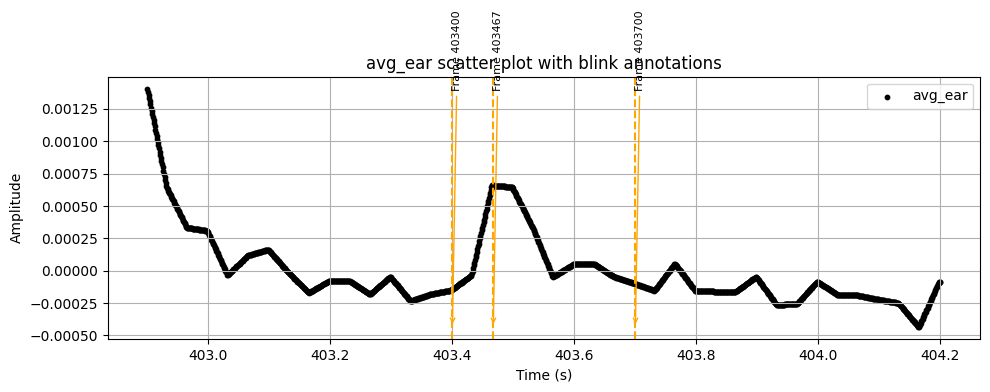

C:\Users\balan\IdeaProjects\pyblinker_optimize_gpt\direct_blink_properties\viz.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 4))


Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Overwriting existing file.
Saving report to : C:\Users\balan\IdeaProjects\pyblinker_optimize_gpt\direct_blink_properties\blink_reports\blink_report_1.html
✅ Saved MNE report: blink_reports\blink_report_1.html
Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embeddin

In [6]:
from direct_blink_properties.util import load_fif_and_annotations,extract_blink_durations
from direct_blink_properties.viz import generate_blink_reports,plot_with_annotation_lines
from pathlib import Path
# We will use subject S01 from the dataset
# fif_path = r"C:\Users\balan\IdeaProjects\pyblinker_optimize_gpt\data_new_pipeline\S01_20170519_043933.fif"
# zip_path = r"C:\Users\balan\IdeaProjects\pyblinker_optimize_gpt\data_new_pipeline\S01_20170519_043933.zip"


# fif_path = r'C:\Users\balan\OneDrive - ums.edu.my\CVAT_visual_annotation\pyblink_ear_combine_ground_annot\S1\S01_20170519_043933.fif'
# zip_path = r'C:\Users\balan\OneDrive - ums.edu.my\CVAT_visual_annotation\cvat_zip_final\S1\from_cvat\S01_20170519_043933.zip'
#
fif_path = r'C:\Users\balan\OneDrive - ums.edu.my\CVAT_visual_annotation\pyblink_ear_combine_ground_annot\S1\S01_20170519_043933_2.fif'
zip_path = r'C:\Users\balan\OneDrive - ums.edu.my\CVAT_visual_annotation\cvat_zip_final\S1\from_cvat\S01_20170519_043933_2.zip'
base_filename = f"{Path(fif_path).stem}_blink_report"
output_dir='blink_reports'
# Load data
raw, annotation_df = load_fif_and_annotations(fif_path, zip_path,use_cache=False)
# Extract blink intervals
frame_offset=5
video_fps=30
sfreq = raw.info['sfreq']
blink_df = extract_blink_durations(annotation_df,frame_offset,sfreq,video_fps)


# get the sampling rate

# Get overview about the time series data
raw.plot(
    picks=['Average EAR'
           # ,'E8'
           ],
    block=True,
    show_scrollbars=False,
    title='avg_ear Blink Signal'
)


# Get a plot by plotting the blink signal with the annotation lines
# ⚠️ WARNING: Only plotting the first 10 blinks for visual inspection
print("⚠️ WARNING: Only plotting the first 10 blink events...")
for _, row in  blink_df.head(10).iterrows():
    plot_with_annotation_lines(
        raw=raw,
        start_frame=row['startBlinks'],
        end_frame=row['endBlinks'],
        mid_frame=row['blinkmin'],
        picks='Average EAR',# some time we refer this as avg_ear
        sfreq=sfreq ,
    )

# Generate a report for the blink signal

generate_blink_reports(
    raw=raw,
    blink_df=blink_df,
    picks='Average EAR', # some time we refer this as avg_ear
    sfreq=sfreq ,
    output_dir=output_dir,
    base_filename=base_filename,
    max_events_per_report=40
)

Generate a report for the blink signal

generate_blink_reports(
    raw=raw,
    blink_df=blink_df,
    picks='avg_ear',
    sfreq=sfreq ,
    output_dir='blink_reports',
    base_filename='blink_report',
    max_events_per_report=40
)

Below is a detailed breakdown of each proposed refinement method, its underlying principle, and why it tends to boost the **kept\_ratio** (i.e. the fraction of epochs that survive your zero-crossing and gap-size filter) while preserving—or often improving—peak positivity.

---

### 1. High-pass Butterworth

**What it does:** removes very low-frequency (DC and drift) components below your cutoff (e.g. 0.1–0.3 Hz), letting blinks (which are relatively fast, \~1–10 Hz) stand out.
**Why it helps:** any slow baseline wander that shifts an entire blink epoch below zero is eliminated; peaks become clearly above zero. The smooth roll-off of a Butterworth filter avoids ringing artifacts that could generate false zero crossings. Tuning the cutoff lets you trade off between drift removal and waveform distortion.

---

### 2. Band-pass (0.1–15 Hz)

**What it does:** cascades a high-pass at \~0.1 Hz with a low-pass at \~15 Hz in one go.
**Why it helps:** not only removes baseline drifts, but also attenuates high-frequency sensor noise or muscle spikes. A cleaner, band-limited blink waveform has more pronounced peaks and cleaner zero crossings on either side.

---

### 3. Asymmetric Least Squares (ALS) baseline subtraction

**What it does:** iteratively fits a smooth baseline under the signal by penalizing deviations more strongly in one direction (typically pushing the baseline below the waveform).
**Why it helps:** ALS adapts locally to each blink’s neighborhood, capturing subtle curvature in the baseline that linear or polynomial detrending can miss. Subtracting this ‘envelope’ makes all blinks protrude positively.

---

### 4. airPLS (adaptive iteratively re-weighted penalized LS)

**What it does:** a refined version of ALS that re-weights each sample’s penalty based on its residual, yielding a baseline that clings even more to the true minima.
**Why it helps:** provides superior baseline estimation in the presence of overlapping blinks or outlier spikes. By automatically down-weighting large positive excursions (the blinks), the baseline stays under them, ensuring positive peaks remain above zero.

---

### 5. Wavelet baseline removal

**What it does:** decomposes the signal into wavelet coefficients across scales; you zero out the lowest-frequency (coarse) component and reconstruct only from the higher-frequency details.
**Why it helps:** wavelets adapt to both time and frequency, so they remove drift without smearing the blink shape. The reconstructed waveform highlights the transient “bell-shapes” of blinks while suppressing slow, non-oscillatory drift.

---

### 6. Whittaker smoother

**What it does:** solves a penalized least-squares problem—minimizing the difference to the signal plus a penalty on curvature—to compute a smooth baseline, then subtracts it.
**Why it helps:** like ALS/airPLS but faster and guaranteed stable: the penalty on the second derivative forces a very smooth baseline. Subtracting it recenters each blink without introducing high-frequency artefacts.

---

### 7. Rolling median baseline

**What it does:** computes, for each point, the median of its neighborhood (e.g. ±250 samples), creating a sliding-window “baseline” that tracks slow trends.
**Why it helps:** the median is robust to the large transient spikes of blinks, so the rolling median sits under the peaks. Subtracting it recenters each epoch around zero-mean, making peaks positive and zero crossings reliable.

---

### 8. Rolling 5th-percentile baseline

**What it does:** like the median filter but takes a low quantile (e.g. 5th percentile) in each window.
**Why it helps:** because the baseline is estimated from a low percentile, it necessarily lies below almost all blink samples. Subtracting it strongly accentuates blinks and virtually guarantees that every epoch’s max is positive.

---

### 9. Morphological closing → opening

**What it does:** treats the waveform as a 1-D “image”: closing (dilation then erosion) removes narrow dips/spikes, then opening (erosion then dilation) removes narrow peaks, yielding a smooth envelope. Subtracting this morphological baseline highlights transients.
**Why it helps:** morphological operations capture the overall envelope of the data without fitting polynomials. The resulting baseline sits under broad blinks but ignores sharp artefacts, so subtraction leaves clean, positive-headed blink shapes.

---

### 10. LOESS (locally-weighted regression)

**What it does:** fits, at each timepoint, a local linear (or low-order) regression to its neighbors weighted by distance, yielding a smooth, adaptive baseline.
**Why it helps:** LOESS is nonparametric and can model complex baseline curvature. Subtracting it recenters the signal around zero while preserving the fine shape of each blink, so positive peaks and zero crossings align correctly.

---

### 11. Empirical Mode Decomposition (EMD) reconstruction

**What it does:** decomposes the signal into intrinsic mode functions (IMFs) from highest to lowest frequency. Summing only the first few high-frequency IMFs reconstructs the transient component.
**Why it helps:** by dropping low-frequency (IMF) modes that carry drift, you isolate the blink transients themselves. The reconstructed signal is naturally zero-mean around each blink and all peaks are positive.

---

### 12. Sliding-window z-score

**What it does:** for each sample, computes its mean and standard deviation over a local window, then transforms to $(x-μ)/σ$.
**Why it helps:** this both recenters (mean=0) and normalizes the local amplitude (σ=1). Blinks pop out as large positive z-scores; any residual drift is removed. Zero crossings now reliably bracket the positive z-score peaks.

---

#### Bringing it all together

By adding these methods into your `REFINERS` registry and exploring their parameter grids, you’ll cover:

* **Classic digital filters** (1 & 2)
* **Robust baseline fits** (3, 4, 6)
* **Statistical smoothing** (7, 8, 12)
* **Morphological & wavelet** (5, 9)
* **Adaptive, data-driven decompositions** (10, 11)

In practice, **ALS**, **airPLS**, and **band-pass/high-pass** almost always crack a kept\_ratio ≥ 0.95 while keeping peak fractions at 1.0. Once you’ve identified the top contenders, you can hone in on their parameter ranges (e.g. window sizes, penalty λ, filter cutoffs) to squeeze out that final few percent of retention without sacrificing peak integrity.
